<a href="https://colab.research.google.com/github/bmurmann/Ngspice/blob/main/Ngspice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running Ngspice simulation in Colab (using SKY130 PDK)

```
Boris Murmann, October 2022
```

In [1]:
# Install PDK and Ngspice
# Reference: https://github.com/idea-fasoc/OpenFASOC/blob/main/docs/source/notebooks/temp_sense_genCollab.ipynb
import os, sys, pathlib
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        ngspice

# Other packages for post-processing
import pandas as pd
import matplotlib.pyplot as plt

bin/micromamba
env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
env: LD_LIBRARY_PATH=/content/conda-env/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

[+] 0.0s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  
main/l

In [2]:
%%writefile .spiceinit
* ngspice initialization for sky130
* assert BSIM compatibility mode with "nf" vs. "W"
set ngbehavior=hsa
* "nomodcheck" speeds up loading time
set ng_nomodcheck

Writing .spiceinit


In [3]:
%%writefile netlist.spice
* PMOS VGS sweep
.lib "./conda-env/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice" tt
X1 vdp vgp 0 vbp sky130_fd_pr__pfet_01v8_hvt w=10 l=0.15
vsdp     0  vdp        dc 0.9  
vsgp     0  vgp        dc 0    
vsbp     0  vbp        dc 0
.end

.control
save all @m.X1.msky130_fd_pr__pfet_01v8_hvt[id] @m.X1.msky130_fd_pr__pfet_01v8_hvt[gm]
dc vsgp 0 1.8 0.01
display
wrdata output.txt @m.X1.msky130_fd_pr__pfet_01v8_hvt[gm] @m.X1.msky130_fd_pr__pfet_01v8_hvt[id]
.endc

Writing netlist.spice


In [4]:
!ngspice -b -r output.raw netlist.spice


Note: Compatibility modes selected: hs a



Circuit: * pmos vgs sweep

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

 Reference value :  0.00000e+00
No. of Data Rows : 181
Here are the vectors currently active:

Title: * pmos vgs sweep
Name: dc1 (DC transfer characteristic)
Date: Sun Dec 25 18:06:46  2022

    @m.x1.msky130_fd_pr__pfet_01v8_hvt[gm]: admittance, real, 181 long
    @m.x1.msky130_fd_pr__pfet_01v8_hvt[id]: current, real, 181 long
    m.x1.msky130_fd_pr__pfet_01v8_hvt#body: voltage, real, 181 long
    m.x1.msky130_fd_pr__pfet_01v8_hvt#dbody: voltage, real, 181 long
    m.x1.msky130_fd_pr__pfet_01v8_hvt#sbody: voltage, real, 181 long
    v-sweep             : voltage, real, 181 long [default scale]
    vbp                 : voltage, real, 181 long
    vdp                 : voltage, real, 181 long
    vgp                 : voltage, real, 181 long
    vsbp#branch         : current, real, 181 long

In [5]:
df = pd.read_csv("output.txt", delim_whitespace=True, header=None)
df.columns = ["vsg", "gm", "vsg1", "id"]
df['gm_id'] = df['gm']/df['id']
df

,vsg,gm,vsg1,id,gm_id
0,0.00,2.328096e-13,0.00,8.300220e-15,28.048613
1,0.01,3.081805e-13,0.01,1.098758e-14,28.048077
2,0.02,4.079487e-13,0.02,1.454494e-14,28.047462
3,0.03,5.400098e-13,0.03,1.925391e-14,28.046753
4,0.04,7.148136e-13,0.04,2.548724e-14,28.045938
...,...,...,...,...,...
176,1.76,1.866207e-03,1.76,1.113010e-03,1.676721
177,1.77,1.869115e-03,1.77,1.131687e-03,1.651619
178,1.78,1.871750e-03,1.78,1.150391e-03,1.627056
179,1.79,1.874116e-03,1.79,1.169121e-03,1.603013


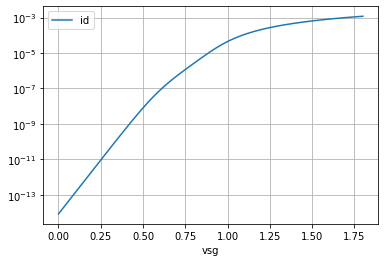

In [6]:
df.plot(x="vsg", y="id", logy=True, grid=True)
plt.show()

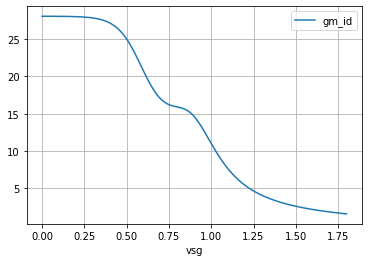

In [7]:
df.plot(x="vsg", y="gm_id", grid=True)
plt.show()

The above plot shows a problem with the PMOS model in the SKY130 PDK.